In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [4]:
# we wrap cadene model to pytorch models format
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [5]:
BATCH_SIZE = 64
sz = 256
NUM_WORKERS = 16
model_name = '20190712-10-se_resnext101_32x4d'

In [6]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.8),
    albumentations.GaussNoise(p=0.05),
    albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=20, always_apply=False, p=0.5),
    albumentations.RandomGamma(gamma_limit=(80, 200), always_apply=True, p=1),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

In [7]:
def loadDfForFold(fold_index = 0):
    #assert ((fold_index >= 0) and (fold_index <= 3)), "fold index must be between 0 and 3"
    df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df['is_valid'] = False
    df_test = pd.read_csv('data/training/test.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df_test['is_valid'] = True
    return pd.concat([df,df_test])

In [8]:
class CustomImageList(ItemList):
    "`ItemList` suitable for computer vision that uses augmentations for training items but not for validation items"
    _bunch,_square_show,_square_show_res = ImageDataBunch,True,True
    def __init__(self, *args, df_copy=None, validation_colname="", data_dir='',data_suffix='', convert_mode='RGB', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix, self.convert_mode,self.after_open = df_copy,validation_colname,data_dir,data_suffix,convert_mode,after_open
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 3,{}

    def get(self, i):
        fn = super().get(i)
        res = self.open(fn)
        self.sizes[i] = res.size
        return res
    
    def open(self, fn)->Image:
        img = cv2.imread(fn)
        # Apply transformations
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix, ''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or ''
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add(pref, res.items.astype(str)), suffix)
        return res
    
    def reconstruct(self, t:Tensor): return Image(t.float().clamp(min=0,max=1))

    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
        if self._square_show_res:
            title = 'Ground truth\nPredictions'
            rows = int(np.ceil(math.sqrt(len(xs))))
            axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12)
            for x,y,z,ax in zip(xs,ys,zs,axs.flatten()): x.show(ax=ax, title=f'{str(y)}\n{str(z)}', **kwargs)
            for ax in axs.flatten()[len(xs):]: ax.axis('off')
        else:
            title = 'Ground truth/Predictions'
            axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
            for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
                x.show(ax=axs[i,0], y=y, **kwargs)
                x.show(ax=axs[i,1], y=z, **kwargs)

In [9]:
def getDataBunch(fold_index = 0):
    df = loadDfForFold(fold_index)
    # Create ImageDataBunch using fastai data block API
    return (CustomImageList.from_df_custom(path='data/patches/',
                                            df=df,
                                            suffix='_0.png', 
                                            df_copy=df, 
                                            validation_colname='is_valid')
                    .split_from_df('is_valid')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
                    # convert to databunch
                    .normalize(imagenet_stats))

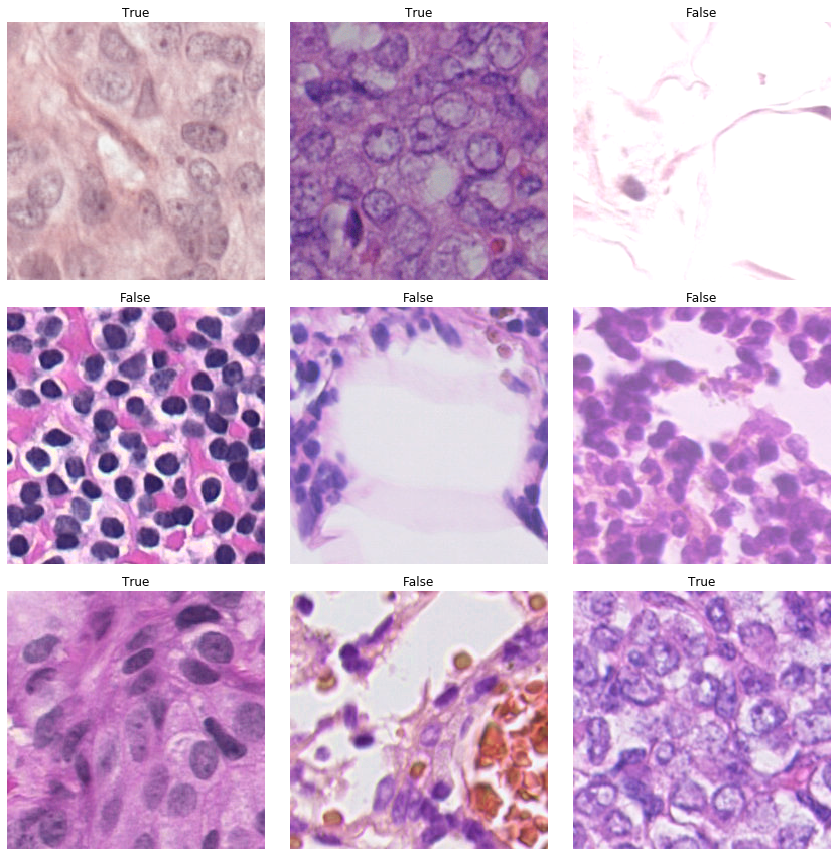

In [10]:
fold_0_databunch = getDataBunch(fold_index=0)
fold_0_databunch.show_batch(rows=3, ds_type=DatasetType.Train)

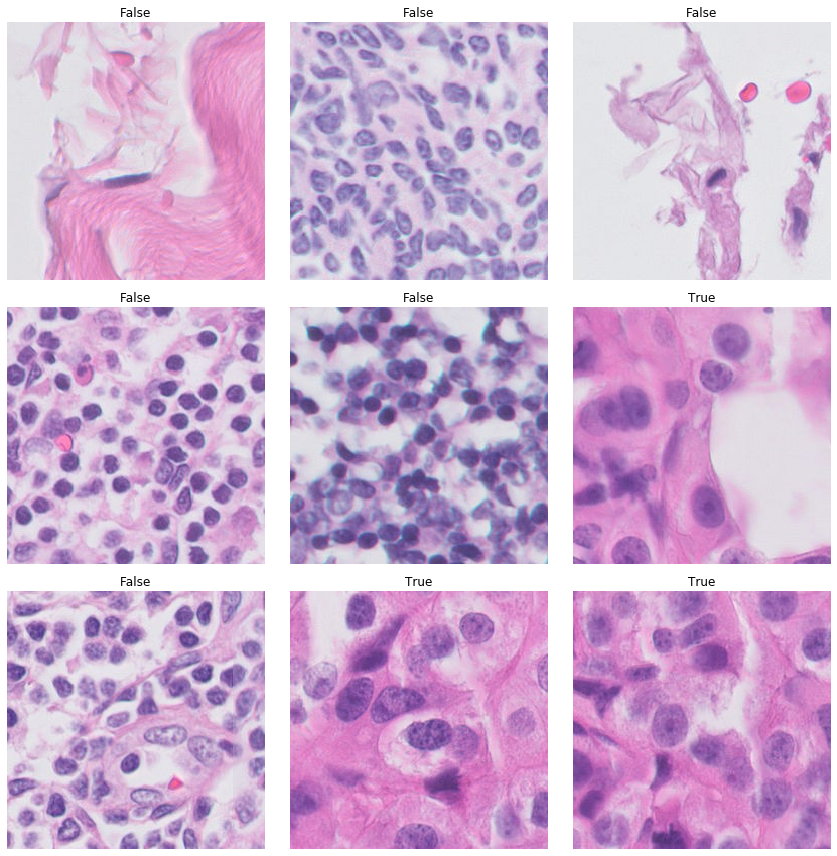

In [11]:
fold_0_databunch.show_batch(rows=3, ds_type=DatasetType.Valid)

In [12]:
def getLearner(dataBunch, modelPath = None):
    learner =  cnn_learner(dataBunch,
                           se_resnext101_32x4d,
                           pretrained=True,
                           path='.',
                           metrics=[accuracy],
                           ps=0.9,
                           callback_fns=ShowGraph)

    learner.crit=nn.BCEWithLogitsLoss()
    if modelPath is not None:
        learner.load(modelPath)
    return learner

In [13]:
from sklearn.metrics import roc_curve, auc

# saved for validation
interp_list = []
preds_list = []
y_list = []
loss_list = []
acc_list = []
tpr_list = []
fpr_list = []
roc_auc_list = []

for fold in [0,1,2,3]:
    print("##########################")
    print("Start inference CV fold " + str(fold))
    print("##########################")
    
        
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=fold)
    
    modelPath = model_name + '_fold' + str(fold) + '_stage-1'
    
    # init new learner
    learner = getLearner(fold_databunch, modelPath)
    
    # get preds for validation 
    preds,y, loss = learner.get_preds(with_loss=True)
    acc = accuracy(preds, y)
    acc_list.append(acc)
    print('The accuracy of the fold {1} model is {0} %.'.format(acc, fold))
    
    interp = ClassificationInterpretation.from_learner(learner)
    
    preds_list.append(preds)
    y_list.append(y)
    loss_list.append(loss)
    interp_list.append(interp)
    
    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area of the fold {1} is {0}'.format(roc_auc, fold))
    
    roc_auc_list.append(roc_auc)

ROC area of the fold 3 is 0.9333699807007597


In [ ]:
for i, interp in enumerate(interp_list):
    interp.plot_confusion_matrix(normalize=True, title="Fold {0}:".format(i))

In [ ]:
for fold , acc in enumerate(acc_list):
    print('The accuracy of the fold {1} model is {0} %.'.format(acc*100, fold))

In [ ]:
for fold , auc in enumerate(roc_auc_list):
    print('The AUC of the fold {1} model is {0} %.'.format(auc*100, fold))
print('The average AUC of all folds is {0} %'.format(np.asarray(roc_auc_list).mean()*100))
print('The std (ddof=1) of AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).std(ddof=1)*100))